<a href="https://colab.research.google.com/github/jongbokhi/master_thesis_2023/blob/main/Feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.feature_selection import SequentialFeatureSelector
import lightgbm as lgb

import statsmodels.api as sm

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
### Load dataset

In [ ]:
df_cic_ids2018 = pd.read_csv('/content/drive/MyDrive/new_cic_ids_2018 data/cleaned_dos.csv')

In [ ]:
print('Class distribution: ')
df_cic_ids2018['Label'].value_counts()

Class distribution: 


0    1190978
1     196868
Name: Label, dtype: int64

In [ ]:
##Sampling
df_cic_ids2018 = df_cic_ids2018.sample(frac=0.1).reset_index(drop=True)

print('Class distribution: ')
df_cic_ids2018['Label'].value_counts()

Class distribution: 


0    119338
1     19447
Name: Label, dtype: int64

In [ ]:
#Set feature variable and target

ids2018_x = df_cic_ids2018.drop('Label', axis=1).copy()
ids2018_y = df_cic_ids2018['Label'].copy()

In [ ]:
#Split dataset into Training and Test and Scaling
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(ids2018_x, ids2018_y, test_size=0.3, random_state=1, stratify=ids2018_y)

In [ ]:
# Scaling
from sklearn.preprocessing import MinMaxScaler

numerical_cols_train = X_train.columns[:63]
numerical_cols_test = X_test.columns[:63]

In [ ]:
numerical_cols_train

Index(['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Bwd Header Len',
       'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max',
       'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt',
       'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt',
       'URG Flag Cnt', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd W

In [ ]:
scaler = MinMaxScaler()
X_train[numerical_cols_train] = scaler.fit_transform(X_train[numerical_cols_train])
X_test[numerical_cols_test] = scaler.transform(X_test[numerical_cols_test])

In [ ]:
#reset index
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [ ]:
concatenated_train = pd.concat([X_train, y_train], axis=1, ignore_index=True)

In [ ]:
new_column_names = list(X_train.columns) + ['Label']
concatenated_train.columns = new_column_names

In [ ]:
concatenated_train

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_17,Protocol_6,Label
0,0.005540,0.001202,0.000214,0.000043,0.000006,0.003154,0.000000,0.012628,0.013222,0.091096,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
1,0.000002,0.000000,0.000053,0.000005,0.000003,0.001036,0.031507,0.007787,0.000000,0.064384,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
2,0.049690,0.000902,0.000214,0.000011,0.000009,0.002185,0.000000,0.004105,0.009124,0.158904,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
3,0.035520,0.001202,0.000160,0.000107,0.000015,0.021062,0.000000,0.031654,0.078660,0.282877,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
4,0.034603,0.001202,0.000160,0.000107,0.000012,0.021062,0.000000,0.031654,0.078660,0.223973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97144,0.035631,0.001202,0.000160,0.000107,0.000012,0.021062,0.000000,0.031654,0.078660,0.229452,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
97145,0.047697,0.000902,0.000214,0.000011,0.000009,0.002185,0.000000,0.004105,0.009124,0.158904,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
97146,0.000438,0.000601,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
97147,0.035171,0.001202,0.000160,0.000107,0.000014,0.021062,0.000000,0.031654,0.078660,0.256849,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0


In [ ]:
#2.Feature selection using only Training dataset:

#2.Feature selection using only Training dataset


*   correlation metrics : Point Bi-Serial
*   Weight of Evidence (WOE) and Information Value (IV)
*   Beta coefficients for Logistic regression
*   Recursive Feature Elimination (RFE)
*   BorutaPy
*   Boruta SHAP

In [ ]:
ids2018_x.columns

Index(['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Bwd Header Len',
       'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max',
       'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt',
       'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt',
       'URG Flag Cnt', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd W

In [ ]:
##correlation metrics : Point Bi-Serial
# Categorical - Continuous

from scipy import stats

#1.Select the top n features based on absolute correlation with train_target variable

# Correlation
point_bi_serial_list = ['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Bwd Header Len',
       'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max',
       'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt',
       'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt',
       'URG Flag Cnt', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min',
       'Protocol_17', 'Protocol_6']


point_bi_serial_threshold = .5

################################ Functions #############################################################


def corr_feature_selection(data,target, point_bi_serial_list, point_bi_serial_threshold):

    #Inputs
    # data - Input feature data
    # target - Target Variable
    # pearson_list - list of continuous features (if target is continuous)
    # point_bi_serial_list - list of continuous features (if target is categorical)/
    #                        list of categorical features (if target is continuous)
    # point_bi_serial_threshold - select features if biserial corrrelation is above this


    corr_data = pd.DataFrame()# Calculate point bi-serial
    for i in point_bi_serial_list:
        # Manual Change in Parameters - Point Bi-Serial
        # Link to function parameters - https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pointbiserialr.html
        pbc = stats.pointbiserialr(target, data[i])
        corr_temp_data = [[i,pbc.correlation,"point_bi_serial"]]
        corr_temp_df = pd.DataFrame(corr_temp_data,
                                    columns = ['Feature',
                                               'Correlation',
                                               'Correlation_Type'])
        #corr_data = corr_data.append(corr_temp_df)
        corr_data = pd.concat([corr_data, corr_temp_df], ignore_index=True)

    # Filter NA and sort based on absolute correlation
    corr_data = corr_data.iloc[corr_data.Correlation.abs().argsort()]
    corr_data = corr_data[corr_data['Correlation'].notna()]
    corr_data = corr_data.loc[corr_data['Correlation'] != 1]

    # Add thresholds

    # initialize list of lists
    data = [['point_bi_serial', point_bi_serial_threshold],]
    threshold_df = pd.DataFrame(data, columns=['Correlation_Type','Threshold'])
    corr_data = pd.merge(corr_data,threshold_df,
                         on=['Correlation_Type'],how = 'left')# Select Features with greater than user dfined absolute correlation
    corr_data2 = corr_data.loc[corr_data['Correlation'].abs() > corr_data['Threshold']]
    corr_top_features = corr_data2['Feature'].tolist()
    print(corr_top_features)
    corr_top_features_df = pd.DataFrame(corr_top_features,columns = ['Feature'])
    corr_top_features_df['Method'] = 'Correlation'
    return corr_data,corr_top_features_df
################################ Calculate Correlation #############################################################

corr_data,corr_top_features_df = corr_feature_selection(X_train, y_train, point_bi_serial_list, point_bi_serial_threshold)


corr_data.head(30)

[]


,Feature,Correlation,Correlation_Type,Threshold
0,Fwd IAT Mean,-0.001135,point_bi_serial,0.5
1,Idle Min,-0.001202,point_bi_serial,0.5
2,Idle Mean,0.005491,point_bi_serial,0.5
3,TotLen Fwd Pkts,-0.006762,point_bi_serial,0.5
4,Subflow Fwd Byts,-0.006762,point_bi_serial,0.5
5,TotLen Bwd Pkts,-0.011419,point_bi_serial,0.5
6,Subflow Bwd Byts,-0.011419,point_bi_serial,0.5
7,Fwd IAT Min,0.018156,point_bi_serial,0.5
8,Flow IAT Std,0.018633,point_bi_serial,0.5
9,Idle Max,0.019180,point_bi_serial,0.5


In [ ]:
##Weight of Evidence (WOE) and Information Value (IV)

#2. Select top features based on information value# Information value

show_woe = True
iv_bins = 10
iv_threshold = .1

################################ Functions #############################################################

def iv_woe(data, target, iv_bins,iv_threshold, show_woe):

    #Inputs
    # data - Input Data including target variable
    # target - Target Variable name
    # iv_bins - Number of iv_bins
    # show_woe - show all the iv_bins and features
    # iv_threshold - select features with IV greater than this

    #Empty Dataframe

    newDF,woeDF = pd.DataFrame(), pd.DataFrame()

    #Extract Column Names

    cols = data.columns

    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], iv_bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})

        # Calculate the number of events in each group (bin)

        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']

        # Calculate % of events in each group.
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()

        # Calculate the non events in each group.
        d['Non-Events'] = d['N'] - d['Events']

        # Calculate % of non events in each group.
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        # Calculate WOE by taking natural log of division of %
        # of non-events and % of events

        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " +
              str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars],
                            "IV" : [d['IV'].sum()]},
                           columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)

    # Aggregate IV at feature level
    woeDF_v2 = pd.DataFrame(woeDF.groupby('Variable')['IV'].agg('sum'), columns= ['IV']).reset_index()
    woeDF_v3 = woeDF_v2.sort_values(['IV'], ascending = False)
    IV_df = woeDF_v2[woeDF_v2['IV']> iv_threshold]
    woe_top_features = IV_df['Variable'].tolist()
    print(woe_top_features)
    woe_top_features_df = pd.DataFrame(woe_top_features,columns = ['Feature'])
    woe_top_features_df['Method'] = 'Information_value'

    return newDF, woeDF,IV_df, woe_top_features_df

################################ Calculate IV #############################################################

train_features_v3_temp = pd.concat([y_train, X_train], axis =1)
newDF, woeDF,IV_df, woe_top_features_df = iv_woe(concatenated_train, 'Label', iv_bins,iv_threshold, show_woe)


woeDF.head(n=30)

Information value of Flow Duration is 1.453021
        Variable                Cutoff     N  Events  % of Events  Non-Events  \
0  Flow Duration    (-0.001, 7.64e-06]  9716      79     0.005803        9637   
1  Flow Duration  (7.64e-06, 0.000168]  9714    1449     0.106442        8265   
2  Flow Duration  (0.000168, 0.000493]  9716    4732     0.347609        4984   
3  Flow Duration   (0.000493, 0.00349]  9714    3148     0.231250        6566   
4  Flow Duration     (0.00349, 0.0316]  9715     725     0.053258        8990   
5  Flow Duration      (0.0316, 0.0352]  9714     288     0.021156        9426   
6  Flow Duration      (0.0352, 0.0368]  9715     232     0.017043        9483   
7  Flow Duration      (0.0368, 0.0447]  9715     771     0.056637        8944   
8  Flow Duration       (0.0447, 0.452]  9715    1506     0.110630        8209   
9  Flow Duration          (0.452, 1.0]  9715     683     0.050173        9032   

   % of Non-Events       WoE        IV  
0         0.115363 -

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,Flow Duration,"(-0.001, 7.64e-06]",9716,79,0.005803,9637,0.115363,-2.989665,0.327548
1,Flow Duration,"(7.64e-06, 0.000168]",9714,1449,0.106442,8265,0.098939,0.073096,0.000548
2,Flow Duration,"(0.000168, 0.000493]",9716,4732,0.347609,4984,0.059663,1.762368,0.507467
3,Flow Duration,"(0.000493, 0.00349]",9714,3148,0.231250,6566,0.078601,1.079115,0.164725
4,Flow Duration,"(0.00349, 0.0316]",9715,725,0.053258,8990,0.107618,-0.703444,0.038239
5,Flow Duration,"(0.0316, 0.0352]",9714,288,0.021156,9426,0.112838,-1.674014,0.153476
6,Flow Duration,"(0.0352, 0.0368]",9715,232,0.017043,9483,0.113520,-1.896266,0.182947
7,Flow Duration,"(0.0368, 0.0447]",9715,771,0.056637,8944,0.107068,-0.636797,0.032114
8,Flow Duration,"(0.0447, 0.452]",9715,1506,0.110630,8209,0.098269,0.118478,0.001464
9,Flow Duration,"(0.452, 1.0]",9715,683,0.050173,9032,0.108121,-0.767782,0.044492


In [ ]:
# Print variable names by predictive power
# Assuming woeDF is the DataFrame containing the IV values
# Sort the DataFrame by IV in descending order
woeDF_sorted = woeDF.sort_values('IV', ascending=False)

# Categorize the predictive power based on IV value
woeDF_sorted['Predictive Power'] = pd.cut(woeDF_sorted['IV'],
                                         bins=[-float('inf'), 0.1, 0.3, float('inf')],
                                         labels=['Weak', 'Medium', 'Strong'])

# Filter the DataFrame for IV values greater than 0.1
woeDF_filtered = woeDF_sorted[woeDF_sorted['IV'] > 0.1]

# Extract unique 'Variable' names
unique_variable_table = woeDF_filtered[['Variable', 'Predictive Power']].drop_duplicates().sort_values('Predictive Power', ascending=False)

# Print the unique variable table
print('=================================================================')
print('Features Information Value')
print()
print("IV > 0.1: Predictive power is Weak")
print("0.1 < IV < 0.3: Predictive power is Medium")
print("IV > 0.3: Predictive power is Strong")
print()
print('=================================================================')
print(unique_variable_table)
print()
print('=================================================================')

# Count variable names by predictive power
count_weak = unique_variable_table['Predictive Power'].eq('Weak').sum()
count_medium = unique_variable_table['Predictive Power'].eq('Medium').sum()
count_strong = unique_variable_table['Predictive Power'].eq('Strong').sum()

# Print variable names by predictive power
variable_names_weak = unique_variable_table.loc[unique_variable_table['Predictive Power'] == 'Weak', 'Variable'].tolist()
variable_names_medium = unique_variable_table.loc[unique_variable_table['Predictive Power'] == 'Medium', 'Variable'].tolist()
variable_names_strong = unique_variable_table.loc[unique_variable_table['Predictive Power'] == 'Strong', 'Variable'].tolist()

print("Variable names with weak predictive power:")
print('=================================================================')
print(variable_names_weak)
print('=================================================================')
print("Number of variable names with weak predictive power:", count_weak)
print('=================================================================')
print()
print()
print('=================================================================')
print("Variable names with medium predictive power:")
print('=================================================================')
print(variable_names_medium)
print('=================================================================')
print("Number of variable names with medium predictive power:", count_medium)
print('=================================================================')
print()
print()
print('=================================================================')
print("Variable names with strong predictive power:")
print('=================================================================')
print(variable_names_strong)
print('=================================================================')
print("Number of variable names with strong predictive power:", count_strong)
print('=================================================================')

Features Information Value

IV > 0.1: Predictive power is Weak
0.1 < IV < 0.3: Predictive power is Medium
IV > 0.3: Predictive power is Strong

             Variable Predictive Power
2   Init Fwd Win Byts           Strong
3    Subflow Fwd Pkts           Strong
0         Fwd IAT Min           Strong
1     Bwd Pkt Len Min           Strong
0         Fwd IAT Tot           Strong
..                ...              ...
6     Bwd Pkt Len Max           Medium
4    Subflow Fwd Pkts           Medium
4        Tot Fwd Pkts           Medium
0     Fwd Pkt Len Std           Medium
5     TotLen Fwd Pkts           Medium

[92 rows x 2 columns]

Variable names with weak predictive power:
[]
Number of variable names with weak predictive power: 0


Variable names with medium predictive power:
['Fwd IAT Tot', 'Bwd IAT Std', 'Fwd Header Len', 'Flow IAT Max', 'Flow Duration', 'Flow IAT Min', 'Fwd IAT Max', 'Flow IAT Std', 'Bwd IAT Min', 'Bwd Pkt Len Mean', 'ACK Flag Cnt', 'Subflow Bwd Byts', 'TotLen Bwd Pkts

In [ ]:
##Beta coefficients for Logistic regression:
#Select  the top n features based on absolute value of beta coefficient of features
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# Beta Coefficients
beta_threshold = 10

################################ Functions #######################################

def beta_coeff(data, train_target,beta_threshold):

    #Inputs
    # data - Input feature data
    # train_target - Target variable training data
    # beta_threshold - select n features with highest absolute beta coeficient value

    # Standardise dataset

    #scaler = StandardScaler()
    #data = pd.DataFrame(scaler.fit_transform(data))
    #data.columns = data.columns

# Fit Logistic on Standardised dataset
    # Manual Change in Parameters - Logistic Regression
    # Link to function parameters - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

    log = LogisticRegression(fit_intercept = False, penalty = 'none')

    log.fit(data, train_target)

    coef_table = pd.DataFrame(list(data.columns)).copy()

    coef_table.insert(len(coef_table.columns),"Coefs", log.coef_.transpose())

    coef_table = coef_table.iloc[coef_table.Coefs.abs().argsort()]

    sr_data = coef_table.tail(beta_threshold)

    beta_top_features = sr_data.iloc[:,0].tolist()

    print(beta_top_features)

    beta_top_features_df = pd.DataFrame(beta_top_features,columns = ['Feature'])
    beta_top_features_df['Method'] = 'Beta_coefficients'
    log_v2 = sm.Logit(train_target,\
                     sm.add_constant(data[beta_top_features])).fit()
    print('Logistic Regression with selected features')
    print(log_v2.summary())

    return log, log_v2, beta_top_features_df

################################ Calculate Beta Coeff ################################################

standardised_logistic, logistic_beta_features, beta_top_features_df = beta_coeff(X_train, y_train, beta_threshold)
beta_top_features_df.head(n=20)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['Fwd Pkt Len Max', 'Idle Max', 'Bwd IAT Tot', 'Fwd Seg Size Min', 'Bwd IAT Mean', 'Protocol_17', 'Bwd IAT Std', 'Pkt Len Std', 'Bwd Pkt Len Std', 'Fwd Pkt Len Std']


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.049197
         Iterations: 35
Logistic Regression with selected features


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:                  Label   No. Observations:                97149
Model:                          Logit   Df Residuals:                    97138
Method:                           MLE   Df Model:                           10
Date:                Fri, 09 Jun 2023   Pseudo R-squ.:                  0.8786
Time:                        20:49:40   Log-Likelihood:                -4779.4
converged:                      False   LL-Null:                       -39364.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -18.0061      0.234    -76.835      0.000     -18.465     -17.547
Fwd Pkt Len Max  -1407.6207     51.377    -27.398      0.000   -1508.317   -1306.924
Idle Max             1.9207 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


,Feature,Method
0,Fwd Pkt Len Max,Beta_coefficients
1,Idle Max,Beta_coefficients
2,Bwd IAT Tot,Beta_coefficients
3,Fwd Seg Size Min,Beta_coefficients
4,Bwd IAT Mean,Beta_coefficients
5,Protocol_17,Beta_coefficients
6,Bwd IAT Std,Beta_coefficients
7,Pkt Len Std,Beta_coefficients
8,Bwd Pkt Len Std,Beta_coefficients
9,Fwd Pkt Len Std,Beta_coefficients


In [ ]:
'''
##L1 regularization to Logistic Regression (Lasso with Logistic regression)
#Select the features identified by Lasso regression

lasso_param = 0.5

################################ Functions ##################################################

def lasso(data, train_target, lasso_param):

    #Inputs
    # data - Input feature data
    # train_target - Target variable training data
    # lasso_param - Lasso l1 penalty term

    #Fit Logistic
    # Manual Change in Parameters - Logistic Regression
    # Link to function parameters - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

    log = LogisticRegression(penalty ='l1', solver = 'saga',\
                             C = lasso_param, max_iter= 300)
    log.fit(data, train_target)

    #Select Features
    lasso_df = pd.DataFrame(columns = ['Feature', 'Lasso_Coef'])
    lasso_df['Feature'] = data.columns
    lasso_df['Lasso_Coef'] = log.coef_.squeeze().tolist()
    lasso_df_v2 = lasso_df[lasso_df['Lasso_Coef'] !=0]
    lasso_top_features = lasso_df_v2['Feature'].tolist()

    lasso_top_features_df = pd.DataFrame(lasso_top_features,\
                                         columns = ['Feature'])
    lasso_top_features_df['Method'] = 'Lasso'

    # Logistic Regression with selected features
    log_v2 = sm.Logit(train_target,\
                   sm.add_constant(data[lasso_top_features])).fit()
    print('Logistic Regression with selected features')
    print(log_v2.summary())

    return log_v2, lasso_top_features_df


################################ Calculate Lasso ################################################

logistic_lasso_features, lasso_top_features_df = lasso(X_train, y_train, lasso_param)

lasso_top_features_df.head(n=20)

Optimal number of features: 25
['Flow Duration', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Min', 'Bwd IAT Tot', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'FIN Flag Cnt', 'URG Flag Cnt', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Seg Size Min']


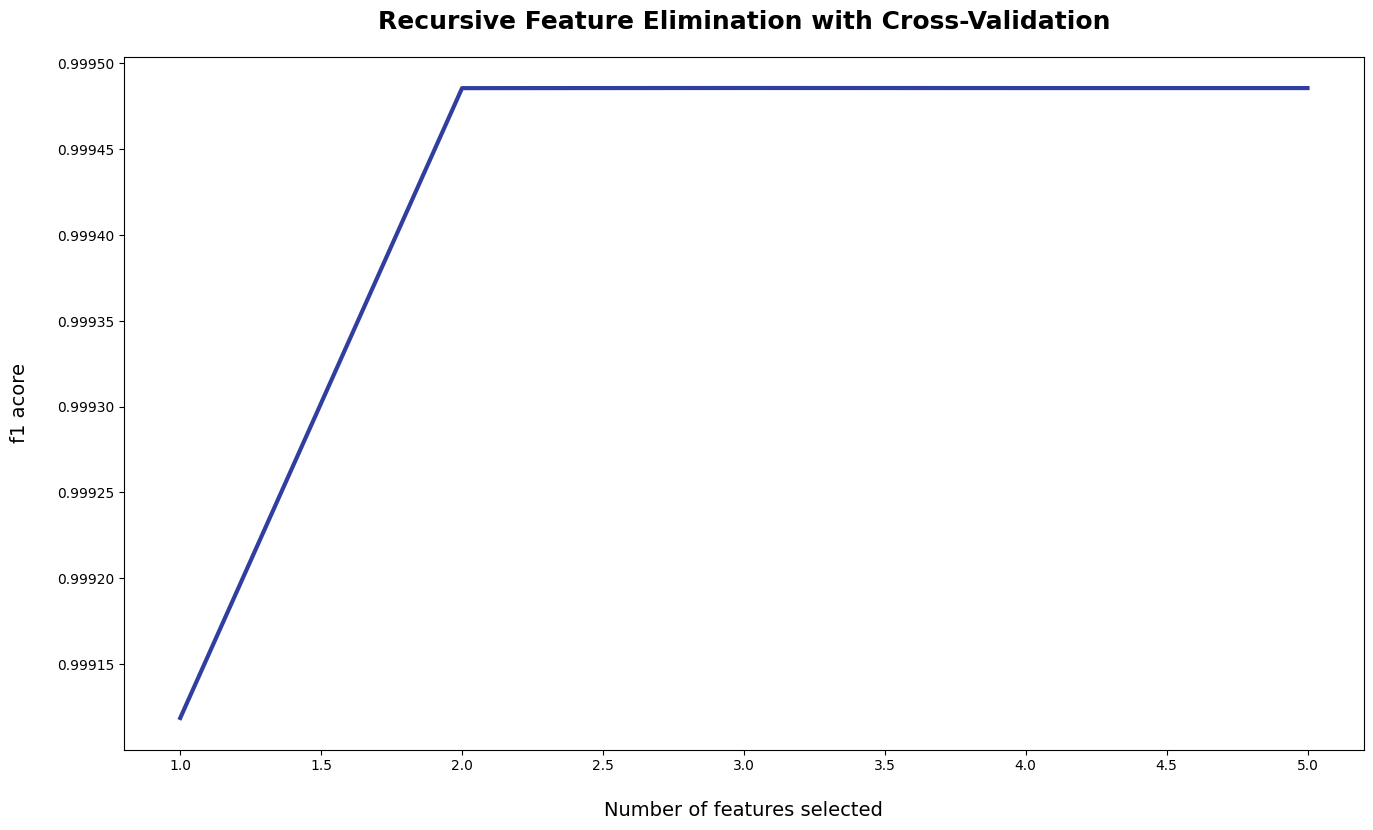

,Feature,Method
0,Flow Duration,RFECV
1,Tot Bwd Pkts,RFECV
2,TotLen Fwd Pkts,RFECV
3,TotLen Bwd Pkts,RFECV
4,Fwd Pkt Len Max,RFECV
5,Fwd Pkt Len Min,RFECV
6,Fwd Pkt Len Std,RFECV
7,Bwd Pkt Len Max,RFECV
8,Flow IAT Mean,RFECV
9,Flow IAT Max,RFECV


In [ ]:
##Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFECV
#Select features based on Recursive Feature Selection method

# RFECV

rfe_estimator = "LightGBM"
rfe_step = 2
min_features = 20
rfe_cv = 5
rfe_scoring = 'f1'

################################ Functions #############################################################

def rfecv_feature_selection(data, train_target, rfe_estimator, min_features, rfe_step, rfe_cv, rfe_scoring):

    #Inputs
    # data - Input feature data
    # train_target - Target variable training data
    # rfe_estimator - base model (default: Decision Tree)
    # rfe_step -  number of features to remove at each iteration
    # rfe_cv - cross-validation splitting strategy
    # rfe_scoring - CV performance scoring metric

    ## Initialize RFE

    if rfe_estimator == "XGBoost":
        # Manual Change in Parameters - XGBoost
        # Link to function parameters - https://xgboost.readthedocs.io/en/stable/parameter.html
        estimator_rfe = XGBClassifier(n_jobs = -1, random_state=101)

    elif rfe_estimator == "RandomForest":
        # Manual Change in Parameters - RandomForest
        # Link to function parameters - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
        estimator_rfe = RandomForestClassifier(n_jobs = -1, random_state=101)

    elif rfe_estimator == "CatBoost":
        # Manual Change in Parameters - CatBoost
        # Link to function parameters - https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier
        estimator_rfe = CatBoostClassifier(iterations=50,verbose=0,random_state=101)

    elif rfe_estimator == "LightGBM":
        # Manual Change in Parameters - LightGBM
        # Link to function parameters - https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
        estimator_rfe = lgb.LGBMClassifier(n_jobs = -1, random_state=101)

    else:
        # Manual Change in Parameters - DecisionTree
        # Link to function parameters - https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
        estimator_rfe = DecisionTreeClassifier(random_state=101)

    # Fit RFECV
    # Manual Change in Parameters - RFECV
    # Link to function parameters - https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html
    # Scoring metrics - https://scikit-learn.org/stable/modules/model_evaluation.html
    rfecv = RFECV(estimator = estimator_rfe, step = rfe_step, min_features_to_select = min_features, cv = rfe_cv, scoring = rfe_scoring)
    rfecv.fit(data, train_target)

    # Select feature based on RFE
    print('Optimal number of features: {}'.format(rfecv.n_features_))
    rfe_df = pd.DataFrame(columns = ['Feature', 'rfe_filter'])
    rfe_df['Feature'] = data.columns
    rfe_df['rfe_filter'] = rfecv.support_.tolist()
    rfe_df_v2 = rfe_df[rfe_df['rfe_filter']==True]
    rfe_top_features = rfe_df_v2['Feature'].tolist()
    print(rfe_top_features)

    rfe_top_features_df = pd.DataFrame(rfe_top_features,columns = ['Feature'])
    rfe_top_features_df['Method'] = 'RFECV'

# Plot CV results
    %matplotlib inline
    plt.figure(figsize=(16, 9))
    plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
    plt.ylabel('f1 acore', fontsize=14, labelpad=20)
    #plt.plot(range(1, len(rfecv.cv_results_) + 1), list(rfecv.cv_results_.values()), color='#303F9F', linewidth=3)
    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], color='#303F9F', linewidth=3)

    plt.show()

    return rfe_top_features_df, rfecv

################################ Calculate RFECV #############################################################

rfe_top_features_df, rfecv = rfecv_feature_selection(X_train, y_train, rfe_estimator, rfe_step, min_features, rfe_cv, rfe_scoring)

rfe_top_features_df.head(n=20)

In [ ]:
'''
###Sequential Feature Selection (SFS)

#6. Select features based on Sequential Feature Selector# Sequential Feature Selector

sfs_feature = 20
sfs_direction = 'backward'
sfs_cv = 5
sfs_scoring = 'f1'

################################ Functions #############################################################

def sfs_feature_selection(data, train_target, sfs_estimator, sfs_feature, sfs_direction, sfs_cv, sfs_scoring):

    #Inputs
    # data - Input feature data
    # train_target - Target variable training data
    # sfs_feature - no. of features to select
    # sfs_direction -  forward and backward selection
    # sfs_cv - cross-validation splitting strategy
    # sfs_scoring - CV performance scoring metric

    ## Initialize RFE

    if sfs_estimator == "XGBoost":
        # Manual Change in Parameters - XGBoost
        # Link to function parameters - https://xgboost.readthedocs.io/en/stable/parameter.html
        estimator_sfs = XGBClassifier(n_jobs = -1, random_state=101)

    elif sfs_estimator == "RandomForest":
        # Manual Change in Parameters - RandomForest
        # Link to function parameters - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
        estimator_sfs = RandomForestClassifier(n_jobs = -1, random_state=101)

    elif sfs_estimator == "CatBoost":
        # Manual Change in Parameters - CatBoost
        # Link to function parameters - https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier
        estimator_sfs = CatBoostClassifier(iterations=50,verbose=0,random_state=101)

    elif sfs_estimator == "LightGBM":
        # Manual Change in Parameters - LightGBM
        # Link to function parameters - https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
        estimator_sfs = lgb.LGBMClassifier(n_jobs = -1, random_state=101)

    else:
        # Manual Change in Parameters - DecisionTree
        # Link to function parameters - https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
        estimator_sfs = DecisionTreeClassifier(random_state=101)




    sfs=SequentialFeatureSelector(estimator = estimator_sfs, n_features_to_select= sfs_feature, direction = sfs_direction,
                   cv = sfs_cv, scoring = sfs_scoring)

    sfs.fit(data, train_target)
    sfs.get_support()

    sfs_df = pd.DataFrame(columns = ['Feature', 'SFS_filter'])
    sfs_df['Feature'] = data.columns
    sfs_df['SFS_filter'] = sfs.get_support().tolist()

    sfs_df_v2 = sfs_df[sfs_df['SFS_filter']==True]
    sfs_top_features = sfs_df_v2['Feature'].tolist()
    print(sfs_top_features)

    x_temp = sm.add_constant(data[sfs_top_features])

    log_v2 = sm.Logit(train_target, x_temp).fit()

    print(log_v2.summary())

    sfs_top_features_df = pd.DataFrame(sfs_top_features\
                                     ,columns = ['Feature'])
    sfs_top_features_df['Method'] ='Sequential_feature_selector'

    # Plot CV results
    %matplotlib inline
    plt.figure(figsize=(16, 9))
    plt.title('Sequential Feature Selection with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
    plt.ylabel('f1 score', fontsize=14, labelpad=20)
    plt.plot(range(1, len(sfs.cv_results_) + 1), list(sfs.cv_results_.values()), color='#303F9F', linewidth=3)

    plt.show()


    return sfs_top_features_df, sfs

################################ Calculate RFECV #############################################################

sfs_top_features_df, sfs = sfs_feature_selection(X_train, y_train, "LightGBM", sfs_feature, sfs_direction, sfs_cv, sfs_scoring)

sfs_top_features_df.head(n=20)

In [ ]:
##BorutaPy
from boruta import BorutaPy
# Select features based on BorutaPy method

  # Features in green area: Important
  # Features in Blue area: Indecisive
  #Features in red area: Reject(considered Noise)

borutapy_estimator = "LightGBM"
borutapy_trials = 10
borutapy_green_blue = "both"


################################ Functions ###########################################

def borutapy_feature_selection(data, train_target, borutapy_estimator, borutapy_trials, borutapy_green_blue):

    #Inputs
    # data - Input feature data
    # train_target - Target variable training data
    # borutapy_estimator - base model (default: XG Boost)
    # borutapy_trials -  number of iteration
    # borutapy_green_blue - choice for green and blue features

    ## Initialize borutapy

    if borutapy_estimator == "RandomForest":
        # Manual Change in Parameters - RandomForest
        # Link to function parameters - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
        estimator_borutapy=RandomForestClassifier(n_jobs = -1,
                                                  random_state=101,
                                                  max_depth=7)
    elif borutapy_estimator == "LightGBM":
        # Manual Change in Parameters - LightGBM
        # Link to function parameters - https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
        estimator_borutapy=lgb.LGBMClassifier(n_jobs = -1,
                                              random_state=101,
                                              max_depth=7)
    else:
        # Manual Change in Parameters - XGBoost
        # Link to function parameters - https://xgboost.readthedocs.io/en/stable/parameter.html
        estimator_borutapy = XGBClassifier(n_jobs = -1,
                                           random_state=101,
                                           max_depth=7)

    ## fit Borutapy
    # Manual Change in Parameters - Borutapy
    # Link to function parameters - https://github.com/scikit-learn-contrib/boruta_py

    borutapy = BorutaPy(estimator = estimator_borutapy,
                        n_estimators = 'auto',
                        max_iter = borutapy_trials)
    borutapy.fit(np.array(data), np.array(train_target))


    ## print results

    green_area = data.columns[borutapy.support_].to_list()
    blue_area = data.columns[borutapy.support_weak_].to_list()
    print('features in the green area:', green_area)
    print('features in the blue area:', blue_area)

    if borutapy_green_blue == "both":
        borutapy_top_features = green_area + blue_area

    else:
        borutapy_top_features = green_area

    borutapy_top_features_df =pd.DataFrame(borutapy_top_features,
                                           columns = ['Feature'])

    borutapy_top_features_df['Method'] = 'Borutapy'

    return borutapy_top_features_df,borutapy

################################ Calculate borutapy ##################################

borutapy_top_features_df,boruta = borutapy_feature_selection(X_train, y_train, borutapy_estimator, borutapy_trials, borutapy_green_blue)

borutapy_top_features_df.head(n=20)

features in the green area: ['Flow Duration', 'TotLen Fwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Bwd Pkt Len Max', 'Flow IAT Min', 'Fwd IAT Min', 'Fwd Pkts/s', 'FIN Flag Cnt', 'URG Flag Cnt', 'Init Fwd Win Byts', 'Fwd Seg Size Min']
features in the blue area: ['Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Mean', 'Fwd IAT Mean', 'Fwd Header Len', 'Init Bwd Win Byts']


,Feature,Method
0,Flow Duration,Borutapy
1,TotLen Fwd Pkts,Borutapy
2,Fwd Pkt Len Max,Borutapy
3,Fwd Pkt Len Min,Borutapy
4,Bwd Pkt Len Max,Borutapy
5,Flow IAT Min,Borutapy
6,Fwd IAT Min,Borutapy
7,Fwd Pkts/s,Borutapy
8,FIN Flag Cnt,Borutapy
9,URG Flag Cnt,Borutapy


  0%|          | 0/10 [00:00<?, ?it/s]

0 attributes confirmed important: []
0 attributes confirmed unimportant: []
65 tentative attributes remains: ['Subflow Fwd Pkts', 'TotLen Bwd Pkts', 'Idle Min', 'Fwd Pkt Len Max', 'Bwd Pkt Len Std', 'Pkt Len Mean', 'Pkt Len Max', 'Fwd IAT Max', 'Fwd Seg Size Avg', 'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Pkt Len Std', 'Flow IAT Mean', 'TotLen Fwd Pkts', 'Bwd IAT Max', 'Bwd Header Len', 'SYN Flag Cnt', 'Idle Std', 'Fwd Pkt Len Std', 'Active Mean', 'Pkt Len Min', 'Bwd IAT Std', 'Tot Bwd Pkts', 'Idle Mean', 'Fwd IAT Min', 'Init Bwd Win Byts', 'Flow Duration', 'Protocol_6', 'Subflow Bwd Pkts', 'Bwd IAT Tot', 'Fwd Pkt Len Min', 'ECE Flag Cnt', 'Subflow Fwd Byts', 'Flow IAT Std', 'Fwd IAT Std', 'PSH Flag Cnt', 'Active Std', 'Fwd Header Len', 'Fwd Pkts/s', 'Fwd IAT Tot', 'Bwd Pkt Len Min', 'Subflow Bwd Byts', 'Idle Max', 'Fwd Pkt Len Mean', 'URG Flag Cnt', 'FIN Flag Cnt', 'Pkt Len Var', 'ACK Flag Cnt', 'Flow IAT Max', 'Active Min', 'Bwd Pkts/s', 'Down/Up Ratio', 'RST Flag Cnt', 'Init Fwd Win

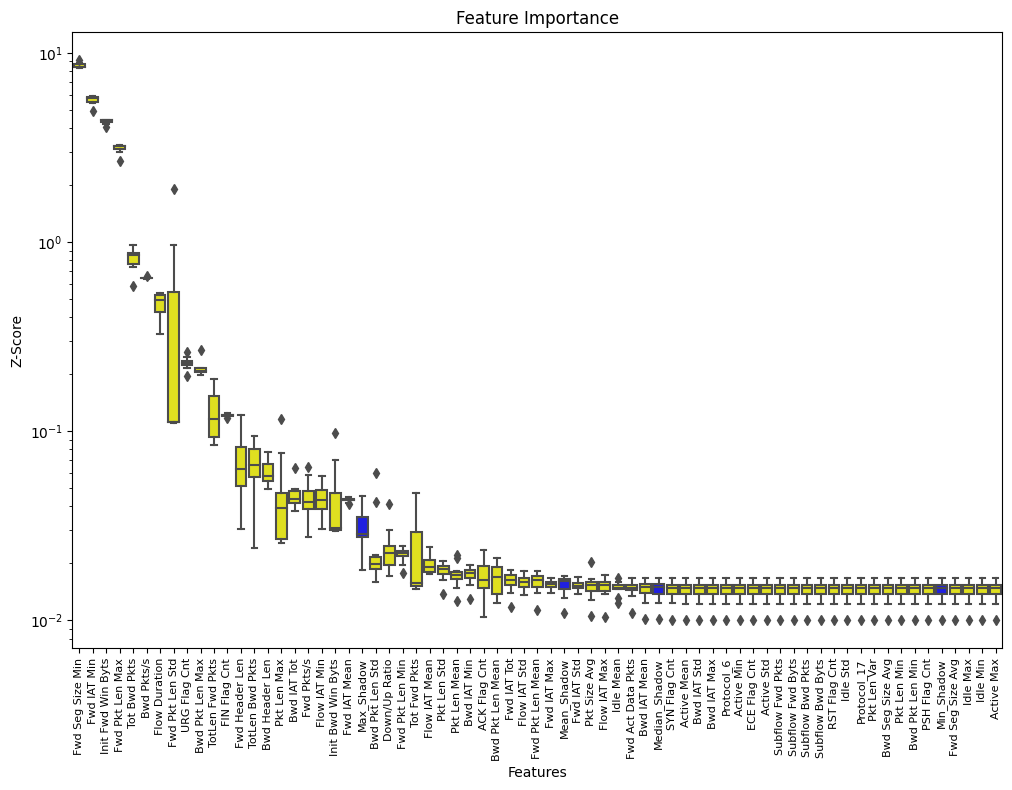

features in the green area: []
features in the blue area: ['Subflow Fwd Pkts', 'TotLen Bwd Pkts', 'Idle Min', 'Fwd Pkt Len Max', 'Bwd Pkt Len Std', 'Pkt Len Mean', 'Pkt Len Max', 'Fwd IAT Max', 'Fwd Seg Size Avg', 'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Pkt Len Std', 'Flow IAT Mean', 'TotLen Fwd Pkts', 'Bwd IAT Max', 'Bwd Header Len', 'SYN Flag Cnt', 'Idle Std', 'Fwd Pkt Len Std', 'Active Mean', 'Pkt Len Min', 'Bwd IAT Std', 'Tot Bwd Pkts', 'Idle Mean', 'Fwd IAT Min', 'Init Bwd Win Byts', 'Flow Duration', 'Protocol_6', 'Subflow Bwd Pkts', 'Bwd IAT Tot', 'Fwd Pkt Len Min', 'ECE Flag Cnt', 'Subflow Fwd Byts', 'Flow IAT Std', 'Fwd IAT Std', 'PSH Flag Cnt', 'Active Std', 'Fwd Header Len', 'Fwd Pkts/s', 'Fwd IAT Tot', 'Bwd Pkt Len Min', 'Subflow Bwd Byts', 'Idle Max', 'Fwd Pkt Len Mean', 'URG Flag Cnt', 'FIN Flag Cnt', 'Pkt Len Var', 'ACK Flag Cnt', 'Flow IAT Max', 'Active Min', 'Bwd Pkts/s', 'Down/Up Ratio', 'RST Flag Cnt', 'Init Fwd Win Byts', 'Tot Fwd Pkts', 'Bwd Seg Size Avg', 'Fwd IA

,Feature,Method
0,Subflow Fwd Pkts,Borutashap
1,TotLen Bwd Pkts,Borutashap
2,Idle Min,Borutashap
3,Fwd Pkt Len Max,Borutashap
4,Bwd Pkt Len Std,Borutashap
5,Pkt Len Mean,Borutashap
6,Pkt Len Max,Borutashap
7,Fwd IAT Max,Borutashap
8,Fwd Seg Size Avg,Borutashap
9,Fwd Act Data Pkts,Borutashap


In [ ]:
##Boruta SHAP

#if you got an error of boston dataset. check the below link.
#https://github.com/IanWord/Boruta-Shap/commit/38af879a27838dc7c884931fe595303e60dd5d42

from BorutaShap import BorutaShap
#Select features based on BorutaShap method

borutashap_estimator = "LightGBM"
borutashap_trials = 10
borutashap_green_blue = 'both'

################################ Functions ###################################################

def borutashap_feature_selection(data, train_target, borutashap_estimator, borutashap_trials, borutashap_green_blue):

    #Inputs
    # data - Input feature data
    # train_target - Target variable training data
    # borutashap_estimator - base model (default: XG Boost)
    # borutashap_trials -  number of iteration
    # borutashap_green_blue - choice for green and blue features

    ## Initialize borutashap

    if borutashap_estimator == "RandomForest":
        # Manual Change in Parameters - RandomForest
        # Link to function parameters - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
        estimator_borutashap=RandomForestClassifier(n_jobs = -1,
                                                    random_state=1,
                                                    max_depth=7)
    elif borutashap_estimator == "LightGBM":
        # Manual Change in Parameters - LightGBM
        # Link to function parameters - https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
        estimator_borutashap=lgb.LGBMClassifier(n_jobs = -1,
                                                random_state=101,
                                                max_depth=7)
    else:
        # Manual Change in Parameters - XGBoost
        # Link to function parameters - https://xgboost.readthedocs.io/en/stable/parameter.html
        estimator_borutashap=XGBClassifier(n_jobs = -1,
                                           random_state=101,
                                           max_depth=7)

    ## fit BorutaShap
    # Manual Change in Parameters - BorutaShap
    # Link to function parameters - https://github.com/scikit-learn-contrib/boruta_py

    borutashap = BorutaShap(model = estimator_borutashap,
                            importance_measure = 'shap',
                            classification = True)

    borutashap.fit(X = data, y = train_target,
                   n_trials = borutashap_trials)

    ## print results
    %matplotlib inline
    borutashap.plot(which_features = 'all')



## print results

    green_area = borutashap.accepted
    blue_area = borutashap.tentative
    print('features in the green area:', green_area)
    print('features in the blue area:', blue_area)

    if borutashap_green_blue == "both":
        borutashap_top_features = green_area + blue_area

    else:
        borutashap_top_features = green_area

    borutashap_top_features_df=pd.DataFrame(borutashap_top_features,
                                            columns = ['Feature'])

    borutashap_top_features_df['Method'] = 'Borutashap'

    return borutashap_top_features_df,borutashap


################################ Calculate borutashap #################################################

borutashap_top_features_df, borutashap = borutashap_feature_selection(X_train, y_train,
                                                                      borutashap_estimator, borutashap_trials, borutashap_green_blue)

borutashap_top_features_df.head(n=20)

In [ ]:
### Combination of feature extraction methos

##I decided to use  17 features based on the result

Selecting features which are picked by more than  3  methods
Final Features Selected:  ['Bwd IAT Tot', 'Bwd Pkt Len Max', 'Flow Duration', 'Flow IAT Min', 'Fwd Header Len', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Fwd Pkts/s', 'Fwd Seg Size Min', 'Init Bwd Win Byts', 'Init Fwd Win Byts', 'Tot Bwd Pkts', 'TotLen Bwd Pkts', 'TotLen Fwd Pkts']


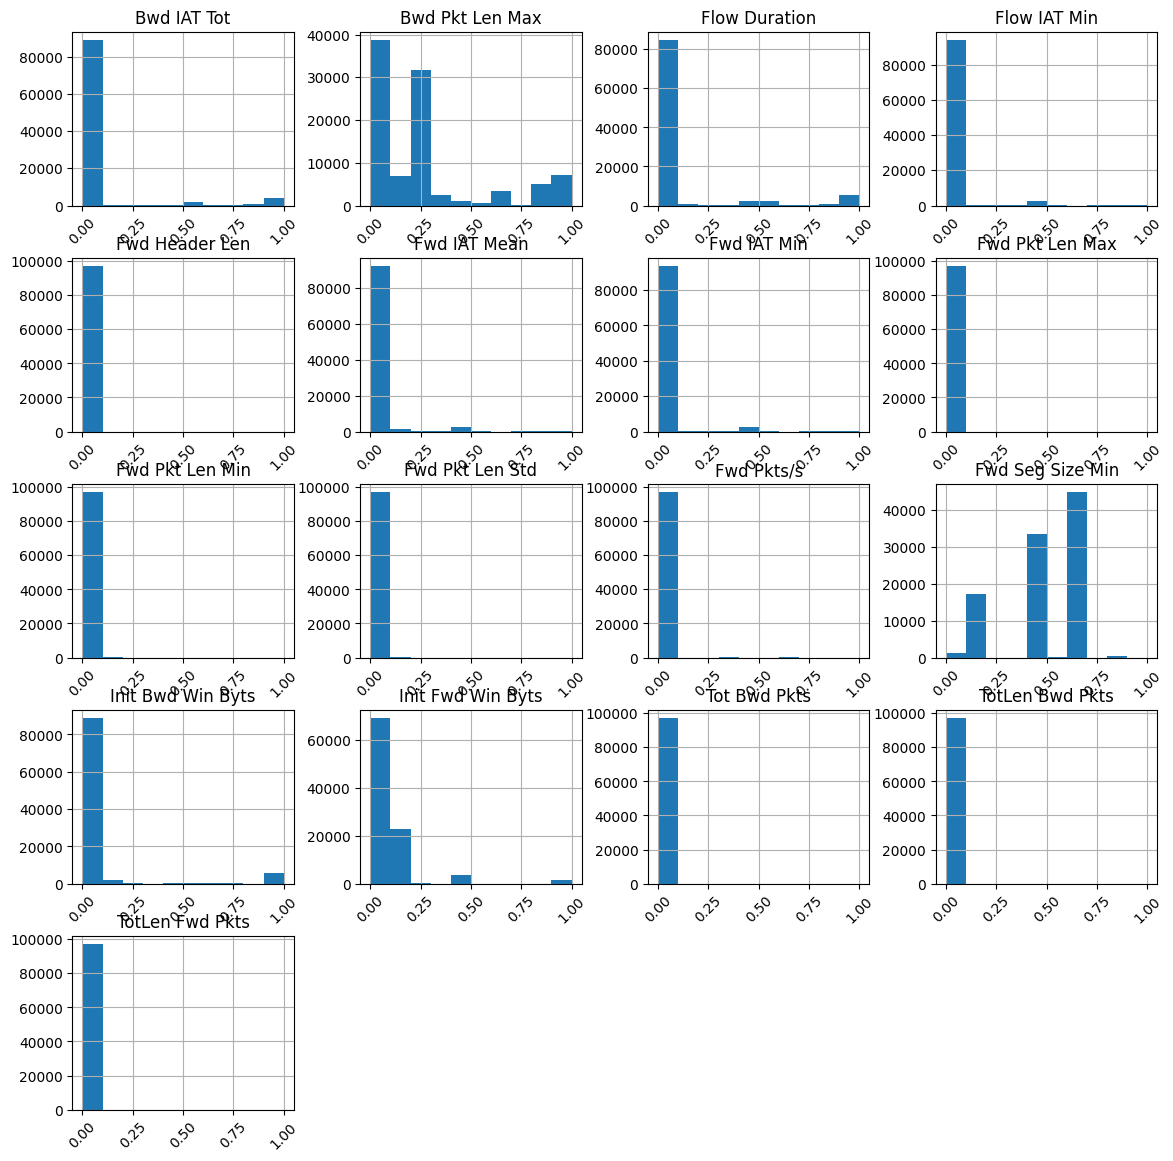

,Features,Count_Method
10,Bwd IAT Tot,4
11,Bwd Pkt Len Max,4
20,Flow Duration,4
23,Flow IAT Min,4
26,Fwd Header Len,4
28,Fwd IAT Mean,4
29,Fwd IAT Min,4
32,Fwd Pkt Len Max,5
34,Fwd Pkt Len Min,4
35,Fwd Pkt Len Std,4


In [ ]:
# Methods Selected
#sfs_top_features_df, lasso_top_features_df

selected_method = [ corr_top_features_df, woe_top_features_df, beta_top_features_df, rfe_top_features_df,
                   borutapy_top_features_df, borutashap_top_features_df]

# Combining features from all the models

master_df_feature_selection = pd.concat(selected_method, axis =0)
number_of_methods = len(selected_method)
selection_threshold = int(len(selected_method)/2)
print('Selecting features which are picked by more than ', selection_threshold, ' methods')

master_df_feature_selection_v2 = pd.DataFrame(master_df_feature_selection.groupby('Feature').size()).reset_index()
master_df_feature_selection_v2.columns = ['Features', 'Count_Method']
master_df_feature_selection_v3 = master_df_feature_selection_v2[master_df_feature_selection_v2['Count_Method'] > selection_threshold]

final_features = master_df_feature_selection_v3['Features'].tolist()

print('Final Features Selected: ', final_features)
X_train[final_features].hist(figsize = (14,14), xrot =  45)
plt.show()
master_df_feature_selection_v3.head(n=20)

##Save features##

In [ ]:
import os
def save_feature(features: pd.Series, dataset_name: str, algorithm: str, tag: str = ""):

    feature_count = features.shape[0]

    if not(tag == ""):
        tag = "_" + tag

    directory = '/content/drive/MyDrive/new_cic_ids_2018 data'
    file_name = f"{dataset_name}_{algorithm}_{feature_count}{tag}"

    # create directory to save the file
    os.makedirs(directory, exist_ok=True)

    features.to_csv(f"{directory}/{file_name}.csv", index=False, columns=None)

    print(f"The features have been saved in {directory}/{file_name}.csv")

In [ ]:
features = pd.Series(master_df_feature_selection_v3['Features'].values.squeeze(), dtype='str')
save_feature(features=features,
             dataset_name='IDS2018_extracted_features_v1',
             algorithm='Combination')

The features have been saved in /content/drive/MyDrive/new_cic_ids_2018 data/IDS2018_extracted_features_v1_Combination_17.csv


In [ ]:
df_ids2018 = pd.read_csv('/content/drive/MyDrive/new_cic_ids_2018 data/cleaned_dos.csv')

In [ ]:
columns = features.tolist() +  ['Label']

df_ids = df_ids2018[columns]

df_ids.shape

(1387846, 18)

In [ ]:
df_ids

,Bwd IAT Tot,Bwd Pkt Len Max,Flow Duration,Flow IAT Min,Fwd Header Len,Fwd IAT Mean,Fwd IAT Min,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Std,Fwd Pkts/s,Fwd Seg Size Min,Init Bwd Win Byts,Init Fwd Win Byts,Tot Bwd Pkts,TotLen Bwd Pkts,TotLen Fwd Pkts,Label
0,0,0,112640768,56300000,0,5.630000e+07,56300000,0,0,0.000000,0.026633,0,-1,-1,0,0,0,0
1,0,0,112641773,56300000,0,5.630000e+07,56300000,0,0,0.000000,0.026633,0,-1,-1,0,0,0,0
2,20700000,64,20784143,66,460,9.404843e+05,66,240,64,54.542292,1.106613,20,255,263,44,1344,2416,0
3,0,0,112640836,56300000,0,5.630000e+07,56300000,0,0,0.000000,0.026633,0,-1,-1,0,0,0,0
4,0,0,20,20,20,0.000000e+00,0,0,0,0.000000,50000.000000,20,0,58856,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387841,0,46,53668766,18,100,1.341719e+07,18,46,0,23.276598,0.093164,20,64,254,1,46,123,0
1387842,0,46,54682783,17,100,1.367070e+07,17,46,0,23.276598,0.091436,20,180,256,1,46,123,0
1387843,0,46,53682093,16,100,1.342052e+07,16,46,0,23.276598,0.093141,20,180,254,1,46,123,0
1387844,0,46,54683364,14,100,1.367084e+07,14,46,0,23.276598,0.091435,20,180,254,1,46,123,0


In [ ]:
df_ids.to_csv('/content/drive/MyDrive/new_cic_ids_2018 data/extracted_ft_dos', index=False)